In [1]:
from __future__ import division
from __future__ import print_function
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle

In [2]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [3]:
# File with gender included
sample10_file = '/Users/lekha/galvanize/capstone/projectRiley/data/sample10/out.txt'
sample1000_file = '/Users/lekha/galvanize/capstone/projectRiley/data/cleandatagender1000.txt'
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/cleandatagenderall.txt'

In [4]:
df = pd.read_csv(sample1000_file, sep="|")

In [5]:
df = df[['full_name', 'html','summary', 'first_name', 'gender', 'counter']]

In [ ]:
# df_all.set_value(18044, 'first_name', 'nanname')
# df_all.set_value(18045, 'first_name', 'nanname')
# df_all.set_value(18046, 'first_name', 'nanname')
# df_all.set_value(18045, 'gender', 'female')
# df_all.set_value(18044, 'gender', 'female')

In [6]:
df['class'] = np.ones(len(df))

In [7]:
df['class'] = df['gender'].apply(lambda x: 0 if x == 'female' else 1)

In [8]:
def f(x):
    if x == 'missing':
        return 1
    else:
        return 0

# Add feature for missing summary
df['summ_missing'] = df['summary'].apply(lambda x: f(x))

In [9]:
# add feature for num of words in the summary
def lenx(mystr):
    return len(mystr.split())

def avgchrs(mytokens):
    tw = len(mytokens)    
    num_chars = 0
    for word in mytokens:
        num_chars += len(word)
        
    return num_chars/tw

In [10]:
df['summ_tokens'] = df['summary'].apply(lambda x: nltk.word_tokenize(x))

In [11]:
df.head()

,full_name,html,summary,first_name,gender,counter,class,summ_missing,summ_tokens
0,ben berkman,./1pridedesign.html\n,landscape design professional with 13 years of...,ben,male,1,1,0,"[landscape, design, professional, with, 13, ye..."
1,john cook phd,./5deep.html\n,working with people and organisations to under...,john,male,1,1,0,"[working, with, people, and, organisations, to..."
2,aakash maniyar,./aakashmaniyar.html\n,hard worker driven to succeed fast learner alw...,aakash,male,1,1,0,"[hard, worker, driven, to, succeed, fast, lear..."
3,aaron buckner,./aaronbucknermusic.html\n,missing,aaron,male,1,1,1,[missing]
4,aaron hawley,./aaronhawley.html\n,missing,aaron,male,1,1,1,[missing]


In [12]:
df['num_tokens'] = df['summ_tokens'].apply(lambda x: len(x))

In [13]:
df['avg_len'] = df['summ_tokens'].apply(lambda x: avgchrs(x))

In [14]:
# For each row, return the total count of first_names that are the same and create a column
#df.drop('name_counts', axis=1, inplace=True)
counts = df.groupby('first_name').size()
counts.name = 'name_counts'

df = df.set_index('first_name').join(counts).reset_index()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bd77c10>]], dtype=object)

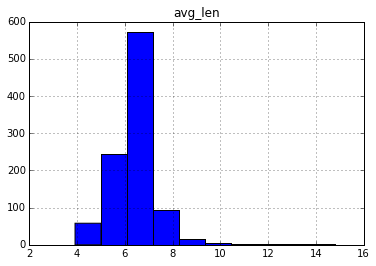

In [15]:
df.hist('avg_len')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10be64850>]], dtype=object)

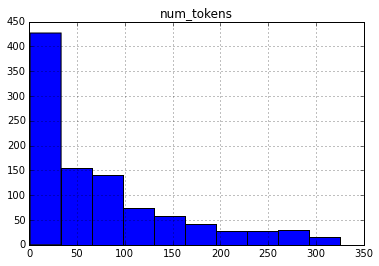

In [16]:
df.hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

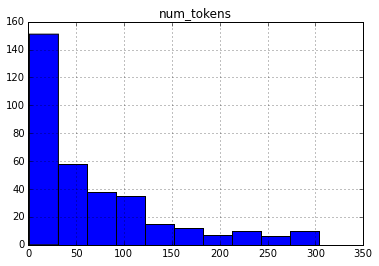

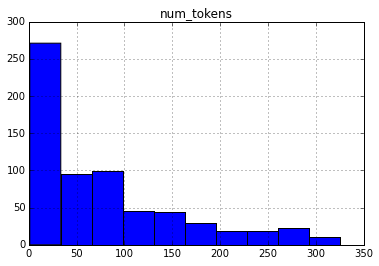

In [17]:
df.groupby('gender').hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

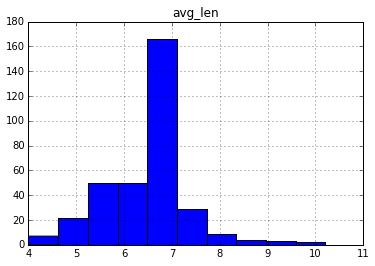

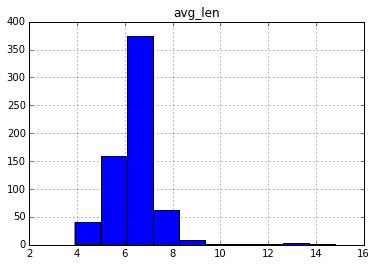

In [18]:
df.groupby('gender').hist('avg_len')

In [19]:
gender_group = df.groupby('gender')

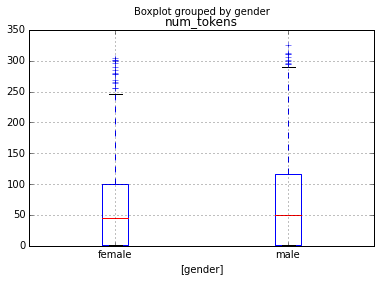

In [20]:
bp = df.boxplot(column=['num_tokens'], by=['gender'])

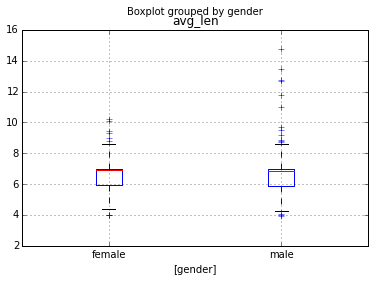

In [21]:
bp = df.boxplot(column=['avg_len'], by=['gender'])

In [22]:
gender_group.describe().T

gender       female                                                         \
              count       mean        std min       25%        50%     75%   
avg_len         342   6.553719   0.902445   4  5.932663   6.936813    7.00   
class           342   0.000000   0.000000   0  0.000000   0.000000    0.00   
counter         342   1.000000   0.000000   1  1.000000   1.000000    1.00   
name_counts     342   2.894737   2.497043   1  1.000000   2.000000    5.00   
num_tokens      342  65.257310  76.220997   1  1.000000  45.500000  100.25   
summ_missing    342   0.336257   0.473120   0  0.000000   0.000000    1.00   

gender                    male                                            \
                     max count       mean        std       min       25%   
avg_len        10.210526   653   6.542285   1.062233  3.918919  5.876984   
class           0.000000   653   1.000000   0.000000  1.000000  1.000000   
counter         1.000000   653   1.000000   0.000000  1.000000  1.000000   
name_counts    11.000000   653   3.924962   4.301042  1.000000  1.000000   
num_tokens    304.000000   653  74.856049  81.656306  1.000000  1.000000   
summ_missing    1.000000   653   0.312404   0.463829  0.000000  0.000000   

gender                                    
                    50%  75%         max  
avg_len        6.818182    7   14.777778  
class          1.000000    1    1.000000  
counter        1.000000    1    1.000000  
name_counts    2.000000    5   20.000000  
num_tokens    50.000000  117  325.000000  
summ_missing   0.000000    1    1.000000

In [23]:
summ_missing = df.groupby('gender').agg({'summ_missing':sum})

In [24]:
sum_gender = df.groupby('gender').agg(np.sum)

In [25]:
avg_gender = df.groupby('gender').agg(np.mean)

In [26]:
avg_gender

,counter,class,summ_missing,num_tokens,avg_len,name_counts
gender,,,,,,
female,1,0,0.336257,65.257310,6.553719,2.894737
male,1,1,0.312404,74.856049,6.542285,3.924962


In [27]:
# Only include rows with summaries
df = df[df['summ_missing'] == 0]

In [28]:
# lexical diversity = number of unique tokens / total number of tokens
df['lex_diversity'] = df['summ_tokens'].apply(lambda x: len(set(x))/len(x))


/Users/lekha/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
df.head()

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

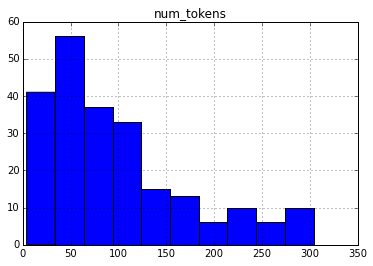

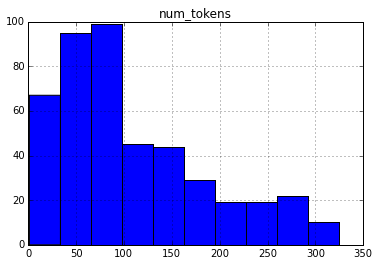

In [29]:
df.groupby('gender').hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

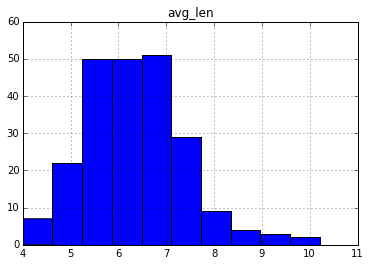

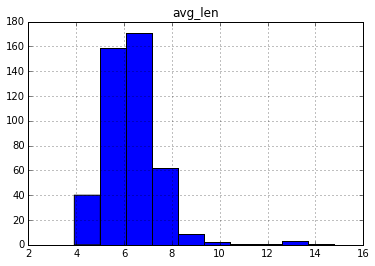

In [30]:
df.groupby('gender').hist('avg_len')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

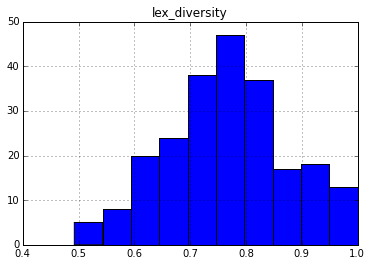

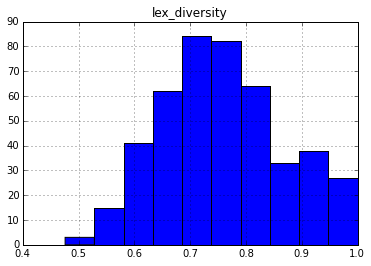

In [31]:
df.groupby('gender').hist('lex_diversity')

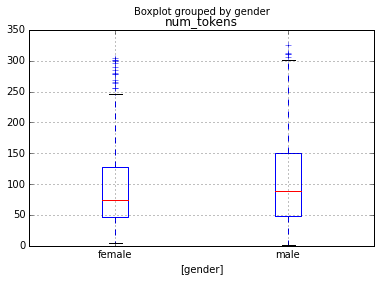

In [32]:
bp = df.boxplot(column=['num_tokens'], by=['gender'])

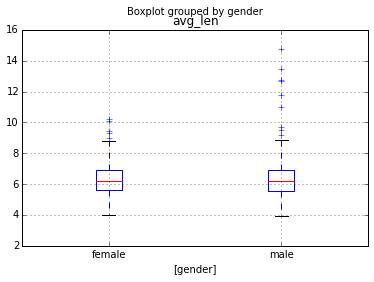

In [33]:
bp = df.boxplot(column=['avg_len'], by=['gender'])

In [34]:
# The breakdown by gender of the final dataset used for train and test
df.gender.value_counts()

male      449
female    227
Name: gender, dtype: int64

# Basic Vocabulary Study

In [35]:
females_df = df[df['gender']=='female']
males_df = df[df['gender'] =='male']

In [36]:
def remove_digits(mystr):
    '''
    INPUT: list of tokens 
    OUTPUT: list of tokens with digits removed
    '''
    return [word for word in mystr if not word.isdigit()]
        

In [39]:
def get_vocab(input_df):
    tokens_by_row = input_df['summ_tokens']
    vocab = []
    for row in tokens_by_row:
        row = remove_digits(row)
        for word in row:
            if word not in stopwords:
                vocab.append(word) 
    return vocab

In [40]:
vocab = get_vocab(df)

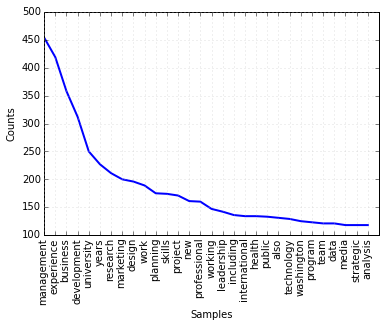

In [42]:
# freq distribution
freq_dist = nltk.FreqDist(vocab)
freq_dist.most_common(30)
freq_dist.plot(30)


In [43]:
f_vocab = get_vocab(females_df)
m_vocab = get_vocab(males_df)

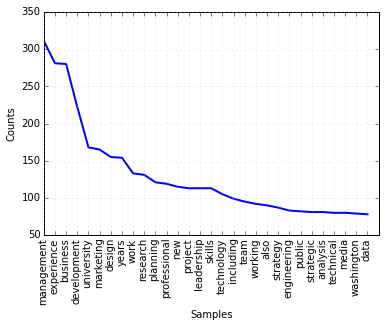

In [44]:
m_freq_dist = nltk.FreqDist(m_vocab)
#freq_dist.N
m_freq_dist.most_common(30)
#freq_dist.freq('management')
m_freq_dist.plot(30)


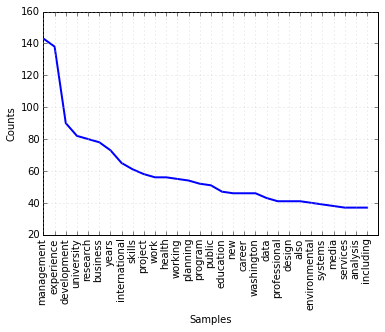

In [45]:
f_freq_dist = nltk.FreqDist(f_vocab)
#freq_dist.N
f_freq_dist.most_common(30)
#freq_dist.freq('management')
f_freq_dist.plot(30)


In [48]:
print (f_freq_dist.freq('experience'))
print (m_freq_dist.freq('experience'))

0.00929355512156
0.00865360926337


# Word Frequencies, Conditional Frequency Distribution for
* ALL,  Male, Female 

In [ ]:
>>> from nltk.probability import ConditionalFreqDist
>>> from nltk.tokenize import word_tokenize
>>> cfdist = ConditionalFreqDist()
>>> for word in word_tokenize(sent):
...     condition = len(word)
...     cfdist[condition][word] += 1

# Predict gender using summary using RF - Baseline Model

In [ ]:
summary_df2['summary'] = summary_df2['summary'].astype(str)

In [ ]:
# summary_df2.set_value(18044, 'first_name', 'nanname')
# summary_df2.set_value(18045, 'first_name', 'nanname')
# summary_df2.set_value(18046, 'first_name', 'nanname')
# summary_df2.set_value(18044, 'name_counts', 3)
# summary_df2.set_value(18045, 'name_counts', 3)
# summary_df2.set_value(18046, 'name_counts', 3)
# summary_df2.set_value(18045, 'gender', 'female')
# summary_df2.set_value(18044, 'gender', 'female')

In [ ]:
# Check for any nans in the DF
summary_df2[pd.isnull(summary_df2).any(axis=1)]


In [ ]:
from nltk import word_tokenize          
import pdb
stemmer = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

def tokenize_no_stem(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return tokens    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(summary_df2['summary'], summary_df2['class'], test_size=0.3, random_state=0)

In [ ]:
temp = np.array(y_test)
len(temp[(temp == 0)])

In [ ]:
print ("Creating the bag of words...\n")
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = tokenize,    \
                             preprocessor = None, \
                             stop_words = stopwords,   \
                             max_features = 5000) 

In [ ]:
tfidf = TfidfVectorizer(analyzer = 'word', tokenizer = tokenize, stop_words = stopwords, max_features = 5000)

In [ ]:
train_tfidf = tfidf.fit_transform(X_train)

In [ ]:
train_tfidf = train_tfidf.toarray()
feature_names = tfidf.get_feature_names()

In [ ]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(X_train)

In [ ]:
# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()
feature_names = vectorizer.get_feature_names()

In [ ]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print (vocab)

In [ ]:
print ("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
#forest = forest.fit(train_data_features, y_train)

forest = forest.fit(train_tfidf, y_train)

In [ ]:
forest

In [ ]:
# Testing

# Get a bag of words for the test set, and convert to a numpy array
#test_data_features = vectorizer.transform(X_test)
test_data_features = tfidf.transform(X_test)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
yhat = forest.predict(test_data_features)
probX = forest.predict_proba(test_data_features)


In [ ]:
probX[:10,:]


In [ ]:
zip(yhat, y_test)
print (probX)

In [ ]:
yhat

In [ ]:
acc = forest.score(test_data_features, y_test)

In [ ]:
acc

In [ ]:
yhat1 = np.ones(yhat.shape)

In [ ]:
yhat.shape

In [ ]:
print ("Precision Score: {0}".format(precision_score(y_test, yhat)))
print ("Recall Score: {0}".format(recall_score(y_test, yhat)))
print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat)))
print ("Model Score:{0}".format(forest.score(test_data_features, y_test)))

In [ ]:
# print ("Precision Score: {0}".format(precision_score(y_test, yhat1)))
# print ("Recall Score: {0}".format(recall_score(y_test, yhat1)))
# print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat1)))
# print ("Model Score:{0}".format(forest.score(test_data_features, y_test)))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probX[:,1])

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probX[:,1])

In [ ]:
fpr2, tpr2, thresholds2 = roc_curve(y_test, probX[:,1])

In [ ]:
thresholds[1:10]

In [ ]:
# ROC Curve
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.array(range(101))/100, np.array(range(101))/100, '--', color='black')
plt.plot(fpr, tpr, label='rf-tfidf')
#plt.plot(fpr1, tpr1, label='rf-stemmed')
#plt.plot(fpr2, tpr2, label='rf-tfidf')
plt.ylabel("True Positive Rate ")
plt.xlabel("False Positive Rate")
plt.title("ROC plot")
plt.legend(loc='lower right')

plt.grid()
plt.show()



In [ ]:
# Most important features
forest.feature_importances_

# Topic Modeling with 5000 features: NMF

### 1. All profiles

In [ ]:
females = summary_df2[summary_df2['gender'] == 'female']
males = summary_df2[summary_df2['gender'] == 'male']

In [ ]:
X = summary_df2['summary']
y = np.array(summary_df2['class'])

In [ ]:
# Print the top 20 words and weights for each topic
def print_top_weights(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        #print (top_weights)
        print (" ".join(["{0}, {1}".format(feature_names[x], topic[x]) for x in top_weights]))
    print()
    

# Print the most probable topic for each document/profile
def profiles_by_topic(W):
    top_idx = np.zeros([W.shape[0],1], dtype=float)
    for row_idx, row in enumerate(W):
        topic_idx = row.argsort()[-1]  
        top_idx[row_idx] = topic_idx
    topics, counts = np.unique(top_idx, return_counts=True)
    print (np.asarray((topics, counts)).T)
    return top_idx

In [ ]:
#tokenize: function that is stemming using SnowballStemmer
#stopwords: custom stop words
def run_topic_model_tfidf(X, stopwords):
    print ("Bag of Words, Tfidf\n")
    
    vectorizer = TfidfVectorizer(analyzer = 'word', tokenizer = tokenize_no_stem, stop_words = stopwords, max_features = 5000)
    word_frequencies = vectorizer.fit_transform(X)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    word_frequencies = word_frequencies.toarray()
    feature_names = vectorizer.get_feature_names()

    # NMF Model to determine topics
    nmf_model = NMF(n_components=10, init='random', random_state=0)
    W = nmf_model.fit_transform(word_frequencies)
    # H: Topics * Words
    H = nmf_model.components_
    print (H.shape, W.shape)
    
    n_top_words = 20
    # Print weights and topics for the top 20 topics
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        print (" ".join(["{0}".format(feature_names[x]) for x in top_weights]))
    print()
    
    # Highest Weighted Topic for each profile
    print ("Number of profiles by topic\n")
    top_idx = profiles_by_topic(W) 
    
    return nmf_model, W, top_idx

In [ ]:
#tokenize: function that is stemming using SnowballStemmer
#stopwords: custom stop words
def run_topic_model_countv(X, stopwords):
    print ("Bag of words, Count Vectorizer...\n")
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = tokenize_no_stem,    \
                                 preprocessor = None, \
                                 stop_words = stopwords,   \
                                 max_features = 5000) 


    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.
    word_frequencies = vectorizer.fit_transform(X)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    word_frequencies = word_frequencies.toarray()
    feature_names = vectorizer.get_feature_names()

    # NMF Model to determine topics
    nmf_model = NMF(n_components=10, init='random', random_state=0)
    W = nmf_model.fit_transform(word_frequencies)
    # H: Topics * Words
    H = nmf_model.components_
    print (H.shape, W.shape)
    
    n_top_words = 20
    # Print weights and topics for the top 20 topics
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        #print (" ".join(["{0}".format(feature_names[x]) for x in top_weights]))
        print (" ".join(["{0}, {1}".format(feature_names[x], topic[x]) for x in top_weights]))
    print()
    
    print ("Number of profiles by Topic\n")
    top_idx = profiles_by_topic(W)
    
    print ("Example Profiles by Topic\n")
    
    
    return nmf_model, W, top_idx

# Topics for Female Profiles - TFIDF

In [ ]:
X = females['summary']
y = np.array(females['class'])

nmf_model, W, top_idx = run_topic_model_tfidf(X, stopwords)


# Female Topics - Count Vectorizer

In [ ]:
X = females['summary']
y = np.array(females['class'])

nmf_model, W, top_idx = run_topic_model_countv(X, stopwords)



# Topics for Male Profiles - TFIDF

In [ ]:
X = males['summary']
y = np.array(males['class'])

nmf_model, W, top_idx = run_topic_model_tfidf(X, stopwords)


# Male Topics - CountVectorizer

In [ ]:
X = males['summary']
y = np.array(males['class'])

nmf_model, W, top_idx = run_topic_model_countv(X, stopwords)

In [ ]:
# Number of profiles clustered by topic number
# Do this again after stemming

In [ ]:
top_idx[1:10]

In [ ]:
males.ix[0]['summary'] # Topic 3

In [ ]:
males.ix[1]['summary'] # Topic 4

In [ ]:
males.ix[4]['summary'] # Topic 9